In [3]:
import pandas as pd
from sklearn import preprocessing


from math import log

from scipy.spatial.distance import euclidean as EUCL
import numpy as np
import pickle

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
plt.rcParams['svg.fonttype'] = 'none'

from scipy.spatial.distance import cdist
from functools import reduce
from operator import add

import warnings
warnings.filterwarnings('ignore')


# Quick Overview:

Consider a test gene *T*, with orthologues in speciesA (*sA*) and speciesB (*sB*).     
     
We define neighborhood of gene T in *sA* (*NA*), the 20 genes with the most similar pattern of expression [1]
for a set of RNAseq experiments in species A.    
Similarly, the neighborhood of the gene in *sB* (*NB*), is calculated based on a range of RNAseq experiments in *sB*. [2]   
     

We can compute the average distance from T to its neighbor genes in *sA* as *DA*,    
and the distance in *sB* as *DB*. These two distances are computed on different sets of RNA data,
so they are not comparable.    
     
To compare the expression of the gene in the two species, we will get the orthologous genes     
of *NA*, and of *NB*. This gives us orthologous Neighborhood A (*NoA*) and *NoB*. *NoA* is a list   
of genes in *sB* and *NoB* is genes of *sA*.[3]

We can now compute *DoA* and *DoB*, the average distance of T to *NoA* and *NoB*.    
*oNA* is a list of distances computed in *sB*, so it's comparable to *NB*,    
and *oNB* is comparable to *NA*.     
     

The NACC value of *T* is then computed like so:     
     
     **NACC = ((*DoA* - *DB*) + (*DoB* - *DA* )) / 2**
     

We calculated NACC values for a subset of genes from each organism, based on their orthology connection to other species. We only used genes from homology families where there is :

*   only one Amphioxus paralogue
    We wanted to avoid gene families that expanded before the WGDs
*   at least one human paralogue but at most 4 human paralogues
    human was our reference species
*   at least one paralogue in species 2 but at most 8
    Again, to avoid gene families with too many members

For the control distributions, we applied exactly the same process, with the only difference being that we had shuffled/randomized the orthology connections.


[1] Based on Euclidean distance
[2] To keep thigs simpler, will will only accept one gene (the one with the smallest distance) per orthologous gene family in a neighborhood. 
[3] Again, for simplicity, from each gene family we will take for orthologous the gene with the smallest distance to T.

In [5]:
def get_results(rpkms, set1,set2, metric):
   
    XB = rpkms.loc[set1,:].copy().fillna(0.0)
    XA = rpkms.loc[set2,:].copy().fillna(0.0)
    
    res = pd.DataFrame(cdist(XA,XB, metric))
    
    res.columns = XB.index
    res.index = XA.index
    del XA,XB

    res = res.reindex(index=list(res.columns) + list(res.index.difference(res.columns))) 
    
    fillval = res.max().max() + 0.01
    
    np.fill_diagonal(res.values, fillval)
    res = res.fillna(fillval)
    
    return res  
def yield_gene_combos(spec2):    
    # To work only with 1-1-1-1-1 genes:
    #foo = gfams.loc[(gfamsC.Hsa==1) & (gfamsC.Mmu==1) & (gfamsC.Dre==1) & (gfamsC.Bla==1) & (gfamsC.Dme==1), ['Hsa',spec2]]
    
    foo = gfams.loc[(gfamsC.Bla==1) & (gfamsC.Hsa>0) & (gfamsC[spec2]>0) & (gfamsC.Hsa<=4) & (gfamsC[spec2]<=8),
                    ['Hsa',spec2]]
#     foo = gfams.loc[(gfamsC.Hsa>0) & (gfamsC[spec2]>0) & (gfamsC.Hsa<=4) & (gfamsC[spec2]<=8),['Hsa',spec2]].copy()

    for irow,row in foo.iterrows():
        for hsagene in row.Hsa:
            yield hsagene, row[spec2]
def get_sets(spec2):
    
    foo = gfams.loc[(gfamsC.Hsa==1) & (gfamsC[spec2]==1),['Hsa',spec2]].copy()
    foo = foo.applymap(lambda x: x[0])
    foo = foo[~foo[spec2].duplicated(keep=False)]
    
    assert len(foo.Hsa) == len(set(foo.Hsa.values)) == len(foo[spec2]) == len(set(foo[spec2].values))
    
    oto1 = foo.Hsa.values
    oto2 = foo[spec2].values

    
    foo = gfams.loc[(gfamsC.Hsa>0) & (gfamsC[spec2]>0),['Hsa',spec2]].copy()
    multi1 = set(reduce(add, foo.Hsa))
    multi2 = set(reduce(add, foo[spec2]))
    
    return oto1,oto2,multi1,multi2

def load_crpkms(fp, css=None):
    crpkms = pd.read_csv(fp, sep='\t').fillna(0)
    crpkms.drop("NAME", axis=1, inplace=True)
    crpkms = crpkms.set_index('ID')
    crpkms = crpkms.applymap(lambda x: log(x+1,10))
    
    if css:
        crpkms = crpkms.loc[:,css]
    
    crpkms = crpkms[crpkms.std(axis=1)>0]   

    return crpkms

In [9]:
def get_naccs(spec2, fp2):
    fp1 = "./data/cRPKM/crpkm_hsa.tab.gz"
    metric = 'euclidean'

    acc_gfams = gfamsC.loc[(gfamsC[spec2]>=1) & (gfamsC.Hsa>=1), : ].index.values

    crpkms1 = load_crpkms(fp1).loc[reduce(add, gfams.loc[(gfamsC[spec2]>=1) & (gfamsC.Hsa>=1), 'Hsa' ]), :].fillna(0.0)
    crpkms2 = load_crpkms(fp2).loc[reduce(add, gfams.loc[(gfamsC[spec2]>=1) & (gfamsC.Hsa>=1), spec2 ]), :].fillna(0.0)

    print("loaded crpkms")
    res1 = pd.DataFrame(cdist(crpkms1,crpkms1, 'euclidean'))
    res2 = pd.DataFrame(cdist(crpkms2,crpkms2, 'euclidean'))
    res1 = res1.set_index(crpkms1.index.values)
    res1.columns = crpkms1.index.values
    res2 = res2.set_index(crpkms2.index.values)
    res2.columns = crpkms2.index.values
    
    yol = res2.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
    res2 = yol.T.reset_index().drop_duplicates(subset='index', keep='last').set_index('index').T

    print("computed distances")

    lon = []
    lon_r = []

    for g1,listog in yield_gene_combos(spec2):

        D_sp1 = pd.DataFrame(res1.loc[g1,:])
        D_sp1['gf'] = D_sp1.index.to_series().map(gfamsD)
        D_sp1 = D_sp1.dropna()
        g1fam = gfamsD[g1]


        for g2 in listog:  
            D_sp2 = pd.DataFrame(res2.loc[g2,:])
            D_sp2['gf'] = D_sp2.index.to_series().map(gfamsD)
            D_sp2 = D_sp2.dropna()
            g2fam = gfamsD[g2]
            if g1fam!=g2fam:
                continue
            ourfam = g1fam

            neigb1 = (D_sp1[(D_sp1.gf!=ourfam) & (D_sp1.gf.isin(acc_gfams))]
                        .sort_values(by=g1)
                        .drop_duplicates(subset='gf')
                        .iloc[:20,:])

            neigb2 = (D_sp2[(D_sp2.gf!=ourfam) & (D_sp2.gf.isin(acc_gfams))]
                        .sort_values(by=g2)
                        .drop_duplicates(subset='gf')
                        .iloc[:20,:])

            m2 = pd.merge(
                    neigb2,
                    (D_sp1
                        .loc[D_sp1.gf.isin(neigb2.gf.values)]
                        .sort_values(by=g1)
                        .drop_duplicates(subset='gf')
                        .set_index('gf')
                        .loc[neigb2.gf.values,:]
                        .reset_index()
                    ),
                    on='gf')

            m2R = (neigb1.loc[:,g1] - D_sp2.sample(20).loc[:,g2].values).abs()

            m1 = pd.merge(
                    neigb1,
                    (D_sp2
                        .loc[D_sp2.gf.isin(neigb1.gf.values)]
                        .sort_values(by=g2)
                        .drop_duplicates(subset='gf')
                        .set_index('gf')
                        .loc[neigb1.gf.values,:]
                        .reset_index()
                    ),
                    on='gf')
            m1R = (neigb2.loc[:,g2] - D_sp1.sample(20).loc[:,g1].values).abs()

            DB = m2[g2].mean()
            DBA = m2[g1].mean()
            DBAR =  D_sp1.sample(20).loc[:,g1].mean()

            DA = m1[g1].mean()
            DAB = m1[g2].mean()
            DABR = D_sp2.sample(20).loc[:,g2].mean()

            NACC = ( (DAB-DA)+(DBA-DB) )/2
            NACCR = ( (DABR-DA)+(DBAR-DB) )/2

            lon.append(NACC)
            lon_r.append(NACCR)
    
    return lon, lon_r

In [7]:
gfams = (pd
            .read_csv("./data/gene_families_table.tsv",
                     sep='\t')
            .applymap(lambda c: c.split(':') if c==c else []))

gfamsC = gfams.applymap(lambda c: len(c))

gfamsD = {}
for rowi, row in gfams.iterrows():
    for species in ['Bla','Dre','Mmu','Hsa','Dme']:
        for gene in row[species]:
            gfamsD[gene] = int(rowi)

In [14]:
%%time
# This is a bit slow:
lon_bla, lonr_bla = get_naccs('Bla', "./data/cRPKM/crpkm_bla.tab.gz")
# lon_mmu, lonr_mmu = get_naccs('Mmu', "./data/cRPKM/crpkm_mmu.tab.gz")
# lon_dre, lonr_dre = get_naccs('Dre', "./data/cRPKM/crpkm_dre.tab.gz")
# lon_dme, lonr_dme = get_naccs('Dme', "./data/cRPKM/crpkm_dme.tab.gz")

loaded crpkms
computed distances
CPU times: user 11min 44s, sys: 6 s, total: 11min 50s
Wall time: 11min 50s


*Because the above process is a bit slow, I have included the reults in pickled objects:*

In [11]:
prec_lon_bla, prec_lonr_bla = pickle.load(open("./data/pickles/finalNACC_allGenes_lon_lonr_BLA.pickle", "rb"))
prec_lon_mmu, prec_lonr_mmu = pickle.load(open("./data/pickles/finalNACC_allGenes_lon_lonr_MMU.pickle", "rb"))
prec_lon_dre, prec_lonr_dre = pickle.load(open("./data/pickles/finalNACC_allGenes_lon_lonr_DRE.pickle", "rb"))
prec_lon_dme, prec_lonr_dme = pickle.load(open("./data/pickles/finalNACC_allGenes_lon_lonr_DME.pickle", "rb"))

In [17]:
sns.set_style('white')

In [21]:
beans = np.linspace(0,10,100)


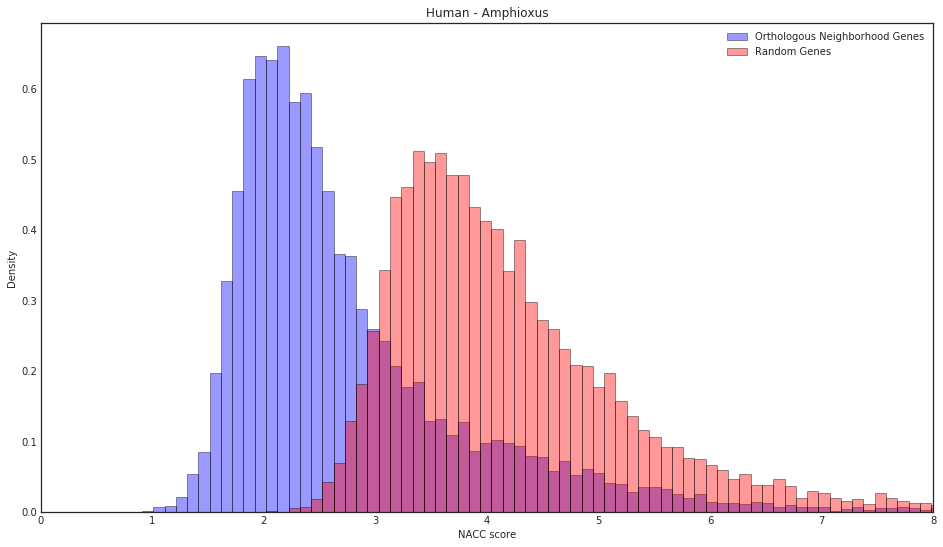

In [23]:
plt.figure(figsize=(16,9))

sns.distplot(prec_lon_bla, 
             kde=False,  
             color='blue',
             bins=beans,
             norm_hist = True, 
             hist_kws={'edgecolor':'black'},
             label="Orthologous Neighborhood Genes")

sns.distplot(prec_lonr_bla,
             kde=False,
             color='red',
             bins=beans,
             norm_hist = True,
             hist_kws={'edgecolor':'black'},
             label="Random Genes")


plt.xlim((0,8))
plt.ylabel("Density")
plt.xlabel("NACC score")
plt.title("Human - Amphioxus")
plt.legend()

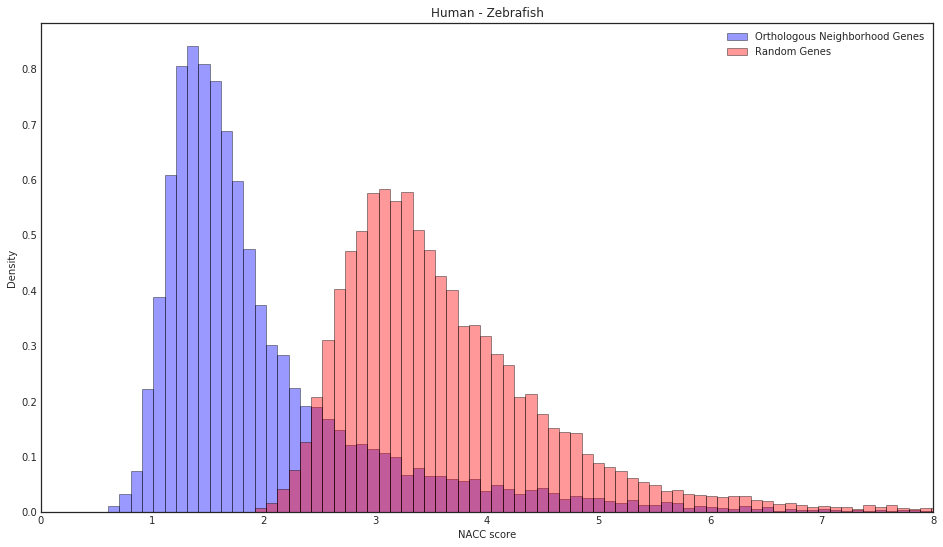

In [26]:
plt.figure(figsize=(16,9))

sns.distplot(prec_lon_dre, 
             kde=False,  
             color='blue',
             bins=beans,
             norm_hist = True, 
             
             hist_kws={'edgecolor':'black'},
             label="Orthologous Neighborhood Genes")

sns.distplot(prec_lonr_dre,
             kde=False,
             color='red',
             bins=beans,
             norm_hist = True,
             hist_kws={'edgecolor':'black'},
             label="Random Genes")

plt.xlim((0,8))
plt.ylabel("Density")
plt.xlabel("NACC score")
plt.title("Human - Zebrafish")
plt.legend()

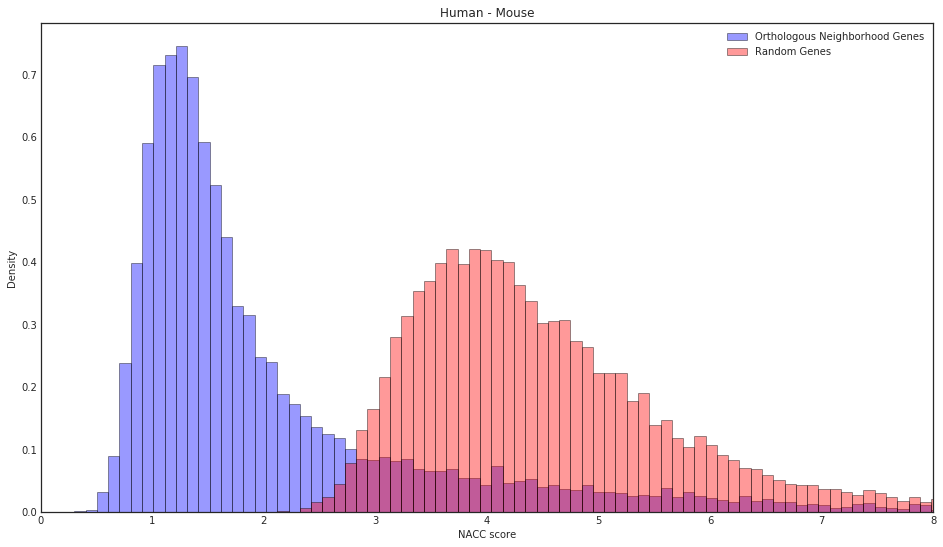

In [25]:
plt.figure(figsize=(16,9))

sns.distplot(prec_lon_mmu, 
             kde=False,  
             color='blue',
             bins=beans,
             norm_hist = True, 
             hist_kws={'edgecolor':'black'},
             label="Orthologous Neighborhood Genes")

sns.distplot(prec_lonr_mmu,
             kde=False,
             color='red',
             bins=beans,
             norm_hist = True,
             hist_kws={'edgecolor':'black'},
             label="Random Genes")


plt.xlim((0,8))
plt.ylabel("Density")
plt.xlabel("NACC score")
plt.title("Human - Mouse")
plt.legend()

### Let's merge all the data together for one single plot:

In [28]:
df_mmu = pd.concat([pd.melt(pd.DataFrame(prec_lon_mmu, columns=['nacc'])), pd.melt(pd.DataFrame(prec_lonr_mmu, columns=['nacc_r']))])
df_mmu['species'] = 'mmu'
df_bla = pd.concat([pd.melt(pd.DataFrame(prec_lon_bla, columns=['nacc'])), pd.melt(pd.DataFrame(prec_lonr_bla, columns=['nacc_r']))])
df_bla['species'] = 'bla'
df_dre = pd.concat([pd.melt(pd.DataFrame(prec_lon_dre, columns=['nacc'])), pd.melt(pd.DataFrame(prec_lonr_dre, columns=['nacc_r']))])
df_dre['species'] = 'dre'
df_dme = pd.concat([pd.melt(pd.DataFrame(prec_lon_dme, columns=['nacc'])), pd.melt(pd.DataFrame(prec_lonr_dme, columns=['nacc_r']))])
df_dme['species'] = 'dme'

biggy = pd.concat([df_bla, df_mmu, df_dre,df_dme])


(0, 7)

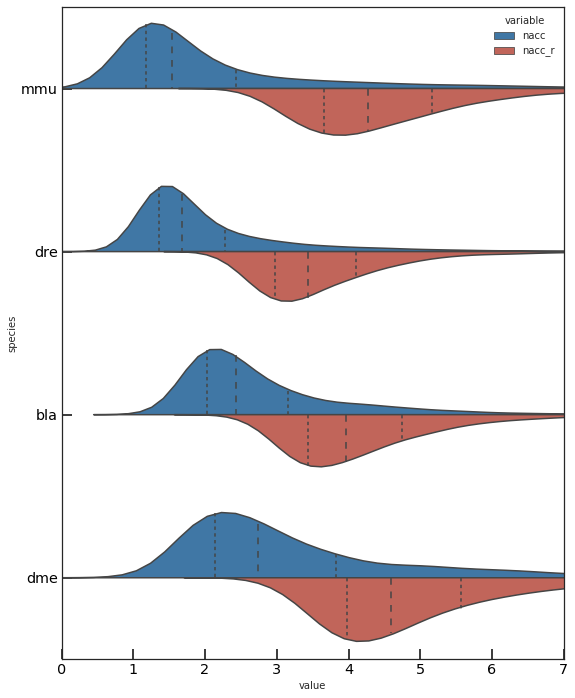

In [29]:
# With some tissues for bla

fig, ax = plt.subplots(figsize=(9,12))


sns.violinplot(data=biggy, y = 'species', hue='variable', x='value', split=True,
               
               
              order = ['mmu','dre','bla','dme'], scale_hue=True, bw=0.2,
              inner= "quartile", 
               palette={'nacc':(0.1843137254901961, 0.47266435986159167, 0.7116493656286044),
                        'nacc_r':(0.8226066897347174, 0.34325259515570933, 0.28627450980392155)
                        },
               ax=ax               
              )

ax.tick_params(direction ='in',
               length=10, width=1.5, colors='black',labelsize='x-large')

plt.xlim((0,7))

(0, 8)

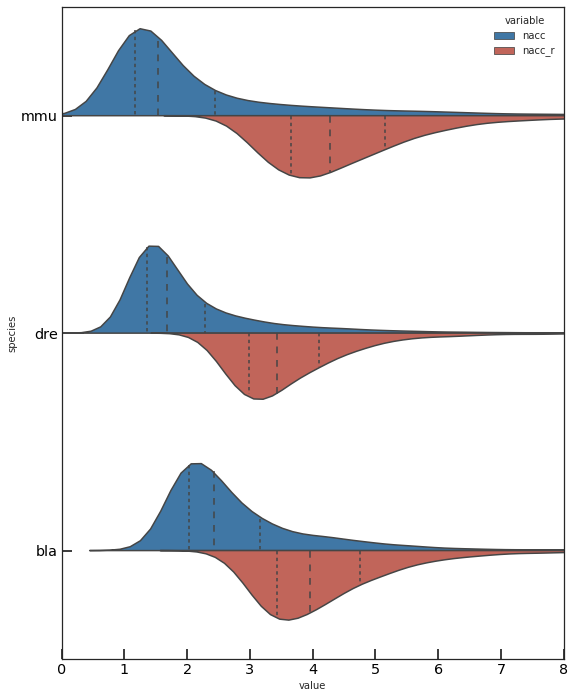

In [31]:
# Maybe without the fly:
fig, ax = plt.subplots(figsize=(9,12))
sns.violinplot(data=biggy, y = 'species', hue='variable', x='value', split=True,               
              order = ['mmu','dre','bla'], scale_hue=True, bw=0.2,
              inner= "quartile", 
#               palette={'nacc':'#4393c3','nacc_r':'#d6604d'}
               palette={'nacc':(0.1843137254901961, 0.47266435986159167, 0.7116493656286044),
                        'nacc_r':(0.8226066897347174, 0.34325259515570933, 0.28627450980392155)
                        },
               ax=ax               
              )
ax.tick_params(direction ='in',
               length=10, width=1.5, colors='black',labelsize='x-large')

plt.xlim((0,8))

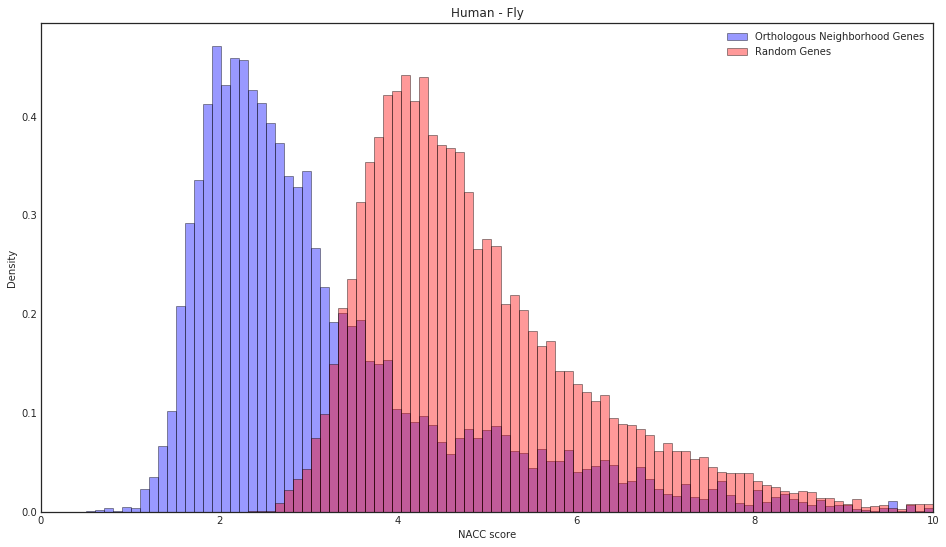

In [32]:
plt.figure(figsize=(16,9))

sns.distplot(prec_lon_dme, 
             kde=False,  
             color='blue',
             bins=beans,
             norm_hist = True, 
             hist_kws={'edgecolor':'black'},
             label="Orthologous Neighborhood Genes")

sns.distplot(prec_lonr_dme,
             kde=False,
             color='red',
             bins=beans,
             norm_hist = True,
             hist_kws={'edgecolor':'black'},
             label="Random Genes")


plt.xlim((0,10))
plt.ylabel("Density")
plt.xlabel("NACC score")
plt.title("Human - Fly")
plt.legend()